# Análisis de Abandono de Clientes (Churn Prediction)

## 1. Carga y Exploración de Datos

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Cargar datos
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(f"Dimensiones: {df.shape}")
df.head()

Dimensiones: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


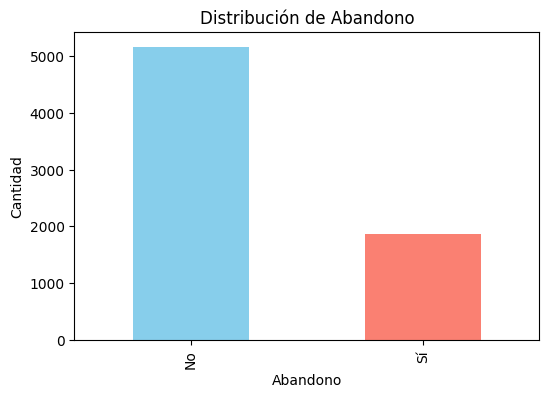

In [4]:
# Distribución de Abandono
plt.figure(figsize=(6,4))
df['Churn'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de Abandono')
plt.xlabel('Abandono')
plt.ylabel('Cantidad')
plt.xticks([0,1], ['No', 'Sí'])
plt.show()

## 2. Preprocesamiento

In [31]:
# Convertir TotalCharges a numérico y manejar valores vacíos
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()

# Eliminar customerID (no es útil para el modelo)
df = df.drop(['customerID'], axis=1)

# Convertir variables categóricas a numéricas
cat_cols = df.select_dtypes(include=['object']).columns.drop('Churn')
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# Convertir variable objetivo
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Separar características y objetivo
X = df.drop('Churn', axis=1)
y = df['Churn']

# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## 3. Modelado (Random Forest)

<Figure size 600x600 with 0 Axes>

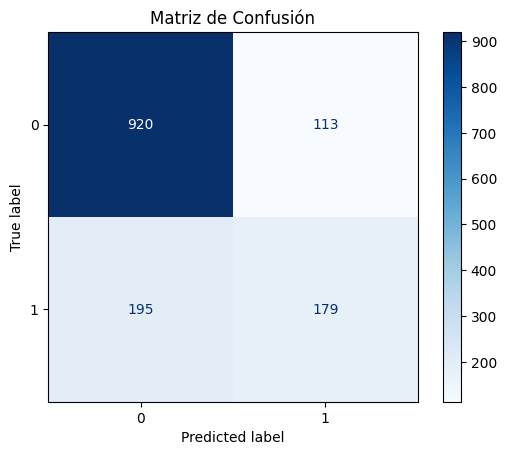

In [ ]:
# Crear y entrenar modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Matriz de confusión
plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

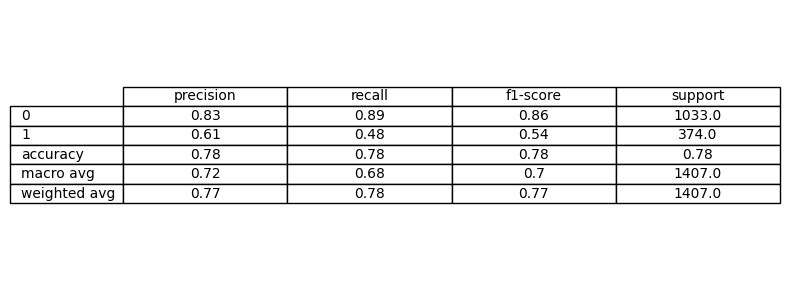

In [40]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(2)
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')
table = ax.table(cellText=report_df.values, colLabels=report_df.columns, rowLabels=report_df.index, loc='center', cellLoc='center')
plt.tight_layout()
plt.show()

## 4. Visualización de Resultados

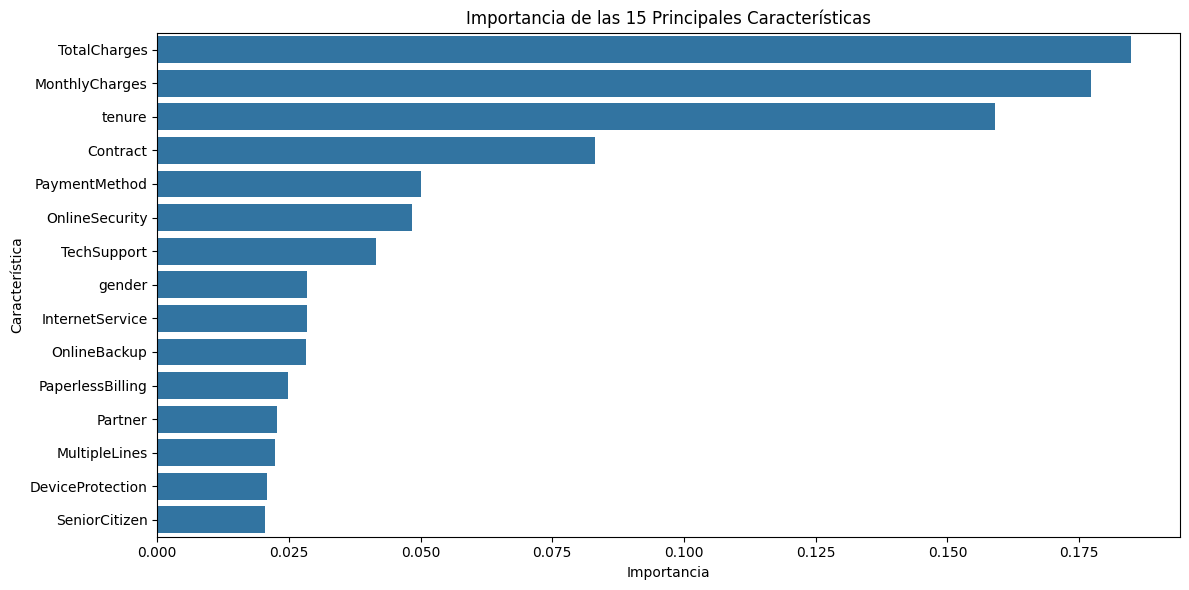

In [34]:
# Importancia de características
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Importancia de las 15 Principales Características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

## 5. Optimización

In [35]:
from sklearn.model_selection import GridSearchCV

# Definir parámetros para búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Búsqueda de mejores parámetros
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                          param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor accuracy:", grid_search.best_score_)

Mejores parámetros: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Mejor accuracy: 0.8028444444444445


## 6. Comparación con Otros Modelos

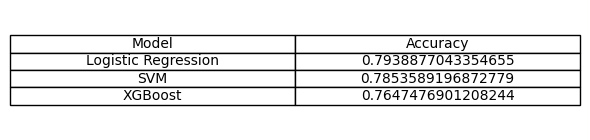

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier()
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc})

results_df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(6, 1.5))
ax.axis('off')
table = ax.table(cellText=results_df.sort_values('Accuracy', ascending=False).values, colLabels=results_df.columns, loc='center', cellLoc='center')
plt.tight_layout()
plt.show()